In [59]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sqlite3
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [60]:
# OBJECTIVES TODAY
''' 
    Normalize the data
    Research models

'''

' \n    Normalize the data\n    Research models\n\n'

In [61]:
# Import Water Data
water_df = pd.read_csv("travis_levels.csv")

# Convert datetime column into month and year 
water_df['date'] = pd.to_datetime(water_df['date'])

# Extract Year and Month
water_df['Year'] = water_df['date'].dt.year
water_df['Month'] = water_df['date'].dt.month

# Drop the original column
water_df.drop(columns=['date'], inplace=True)

# Convert daily data to monthly averages
columns_to_average = [col for col in water_df.columns if col not in ['Year', 'Month']]
water_df = water_df.groupby(['Year', 'Month'], as_index=False)[columns_to_average].mean()

# Generate data remainder of 2025
avg_values = []
for i in range(4, 13):  # April to December
    monthly_df = water_df[water_df['Month'] == i].tail(10)  # Last 10 rows for that month
    avg_row = monthly_df.drop(columns=['Year', 'Month']).mean(numeric_only=True)
    
    # Create a dictionary with 'Year', 'Month', and the averaged values
    row_dict = {'Year': 2025, 'Month': i}
    row_dict.update(avg_row.to_dict())
    
    avg_values.append(row_dict)

avg_df = pd.DataFrame(avg_values)
water_df = pd.concat([water_df, avg_df], ignore_index=True)

# Reorder columns to move 'Year' and 'Month' to index 0 and 1
water_df = water_df[['Year', 'Month'] + [col for col in water_df.columns if col not in ['Year', 'Month']]]

# Create water level columns lagged by: 1, 3, 6, 12 months
water_df['lag1_water_level'] = water_df['water_level'].shift(1)
water_df['lag3_water_level'] = water_df['water_level'].shift(3)
water_df['lag6_water_level'] = water_df['water_level'].shift(6)
water_df['lag12_water_level'] = water_df['water_level'].shift(12)

# Set future values lagged and target column as NaN 
condition = (water_df['Year'] == 2025) & (water_df['Month'] > 6)
for col in ['lag1_water_level', 'lag3_water_level', 'lag6_water_level', 'lag12_water_level', 'water_level']:
    water_df.loc[condition, col] = np.nan

# Viewing all entries where water level is NaN
contains_nan = water_df[water_df['water_level'].isna()]


In [62]:
# Import population data
pop_df = pd.read_csv("austin_population.csv")

# Dictionary of Recent Years
new_rows = [{'Year': 2017, 'City of Austin Population': 951610}, 
            {'Year': 2018, 'City of Austin Population': 962800 },
            {'Year': 2019, 'City of Austin Population': 978763},
            {'Year': 2020, 'City of Austin Population': 995484},
            {'Year': 2021, 'City of Austin Population': 964177 },
            {'Year': 2022, 'City of Austin Population': 975418 },
            {'Year': 2023, 'City of Austin Population': 979882 },
            {'Year': 2024, 'City of Austin Population': 986928},
            {'Year': 2025, 'City of Austin Population': 989252},
            {'Year': 2026, 'City of Austin Population': 993937},
            {'Year': 2027, 'City of Austin Population': 998622}]
temp_df = pd.DataFrame(new_rows)

# Concatenating Dataframes
pop_df = pd.concat([pop_df,  temp_df], axis = 0)


monthly_pop = []
repeating_years = []

for i, population in enumerate(pop_df['City of Austin Population']):
    year = pop_df.iloc[i, 0]
    if i != len(pop_df)-1:

        # Compute change between years and num months
        years_difference = pop_df.iloc[i+1, 0] - pop_df.iloc[i, 0]
        num_months = years_difference * 12

        # Compute total and incremental population change
        pop_difference = pop_df.iloc[i+1, 1] - pop_df.iloc[i, 1]
        pop_increment = pop_difference / 12

        # Compute new monthly values and store in list  (start at initial pop, increment 12 times)
        for i in range(0,12):
            monthly_pop.append(population + pop_increment * i)
            repeating_years.append(year)
           
            

# List of months repeating
months_list = [i for _ in range(int(len(monthly_pop)/12)) for i in range(1, 13)]

# Create new dataframe with updated data
pop_df = pd.DataFrame ({
    'Year': repeating_years, 
    'Month': months_list, 
    'Population': monthly_pop
})

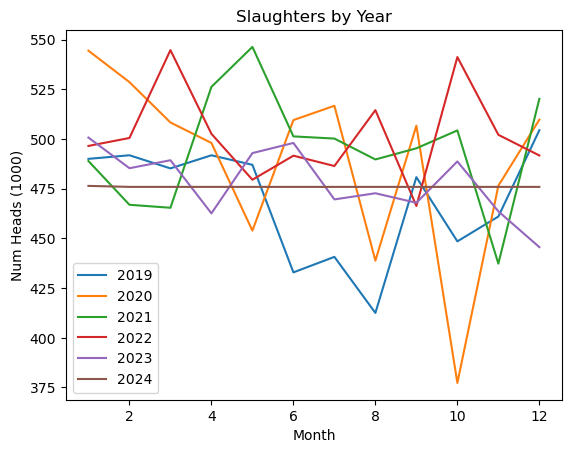

In [63]:
# Import cattle slaughter data   [Return to this later, if using model that handles missing data can use feature]

'''This data was missing entries from Feb - Dec 2024
    Avg values used to fill missing entries
    Values from 1969 and 1993 are average of total year'''

cow_df = pd.read_excel("updated_cattle.xlsx")
cow_df.rename(columns = {'Cattle Slaughter (1,000 head)': 'Cows'}, inplace = True)
# Line graph of cattle numbers

for i in range(2019, 2025):
    # Get corresponding data
    year_data = cow_df[cow_df['Year'] == i]

    # Add to line plot
    plt.plot(year_data['Month'], year_data['Cows'], label = i)

plt.title('Slaughters by Year')
plt.xlabel('Month')
plt.ylabel('Num Heads (1000)')
plt.legend()

In [64]:
# Import Pre 2000 Water Use Data

use1_df = pd.read_excel("Pre2000_water_use.xlsx")
# Drop the first row (index 0)
use1_df = use1_df.drop(0)

# Set the second row (now index 1) as column labels
use1_df.columns = use1_df.iloc[0]
use1_df.drop(1, inplace = True)
use1_df.reset_index(inplace = True, drop = True)


# Filter out rows where the Year is 2000 or greater
df_filtered = use1_df[use1_df['Year'] < 2000]

# Group by 'Year' and 'Source Type' and aggregate the data (sum is an example)
df_grouped = df_filtered.groupby(['Year', 'Source Type'], as_index=False).sum()

# Pivot the DataFrame
df_pivot = df_grouped.pivot(index="Year", columns="Source Type")

# Flatten the MultiIndex columns
df_pivot.columns = [f"{col[1]} {col[0]}" for col in df_pivot.columns]

# Reset the index for a clean DataFrame
use1_df = df_pivot.reset_index()

use1_df.columns = ['Year', 'Municipal Groundwater', 'Municipal Surface Water',
       'Manufacturing Groundwater', 'Manufacturing Surface Water',
       'Mining Groundwater', 'Mining Surface Water', 'Power Groundwater',
       'Power Surface Water', 'Irrigation Groundwater',
       'Irrigation Surface Water', 'Livestock Groundwater',
       'Livestock Surface Water']

# Import recent Water use data and concatenate
use2_df = pd.read_excel('recent_water_use.xlsx')

# Drop unwanted columns
use2_df.drop(['Unnamed: 0', 'Unnamed: 1', 'Municipal Reuse', 'Manufacturing Reuse', 'Mining Reuse & Brackish', 'Power Reuse', 'Irrigation Reuse', 'Livestock Reuse'], axis = 1, inplace = True)

# Concatenate old years w recent years
wateruse_df = pd.concat([use1_df, use2_df], axis = 0).astype(float)
wateruse_df.head()

print('The years that alraedy exist in this dataset are:', set(wateruse_df['Year'].to_list()))

The years that alraedy exist in this dataset are: {1974.0, 1980.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0}


In [65]:
# Connect to SQL database
connection = sqlite3.connect(':memory:')
cursor = connection.cursor()               # cursor is a pointer that allows you to interact with the database to execute SQL commands

# Convert to SQL table
wateruse_df.to_sql('wateruse_table', connection, if_exists = 'replace', index = False)

# Fill data for missing years with averages
query = '''
INSERT INTO wateruse_table (Year, "Municipal Groundwater", "Municipal Surface Water","Manufacturing Groundwater","Manufacturing Surface Water","Mining Groundwater","Mining Surface Water","Power Groundwater","Power Surface Water","Irrigation Groundwater","Irrigation Surface Water","Livestock Groundwater","Livestock Surface Water")
    SELECT
        ?, -- Placeholder for the Year value from Python
        AVG("Municipal Groundwater"),
        AVG("Municipal Surface Water"), 
        AVG("Manufacturing Groundwater"), 
        AVG("Manufacturing Surface Water"), 
        AVG("Mining Groundwater"), 
        AVG("Mining Surface Water"), 
        AVG("Power Groundwater"), 
        AVG("Power Surface Water"), 
        AVG("Irrigation Groundwater"), 
        AVG("Irrigation Surface Water"), 
        AVG("Livestock Groundwater"), 
        AVG("Livestock Surface Water")
    FROM wateruse_table
    WHERE Year BETWEEN ? AND ?;'''

missing_years = [1975, 1976, 1977, 1978, 1979, 1981, 1982, 1983, 2023, 2024, 2025, 2026]
start_yr = 1980
end_yr = 1990
for year in missing_years:
    if year > 2000:
        start_yr = 2010
        end_yr = 2022
    try:
        # Pass the year variable as a tuple to the execute method
        # The order of values in the tuple must match the order of '?' placeholders
        cursor.execute(query, (year,start_yr, end_yr))
        # No commit here for better performance (commit after loop)
    except sqlite3.IntegrityError as e:
        continue
    except sqlite3.Error as e:
        raise # Re-raise the exception to trigger the outer rollback
    

    connection.commit() # Commit all changes after the loop

    wateruse_df = pd.read_sql_query('SELECT * FROM wateruse_table ORDER BY Year ASC', connection)

# Column for water total use
wateruse_df['Total Water'] = wateruse_df.iloc[:, 1:13].sum(axis=1)

# Lagged columns for total water use
wateruse_df['lag1_total_water'] = wateruse_df['Total Water'].shift(1)
wateruse_df['lag3_total_water'] = wateruse_df['Total Water'].shift(3)
wateruse_df['lag6_total_water'] = wateruse_df['Total Water'].shift(6)
wateruse_df['lag12_total_water'] = wateruse_df['Total Water'].shift(12)


# Sample seasonal weights for 12 months — must sum to 1
monthly_weights = {
    1: 0.05, 2: 0.05, 3: 0.06, 4: 0.07,
    5: 0.08, 6: 0.10, 7: 0.16, 8: 0.14,
    9: 0.10, 10: 0.07, 11: 0.07, 12: 0.05
}

# Expand each year into 12 rows (one per month)
expanded_rows = []

for _, row in wateruse_df.iterrows():  # loop through each row of a Pandas DataFrame as a (row_index, row_data) pair
    for month in range(1, 13):
        monthly_row = {'Year': row['Year'], 'Month': month}
        for col in wateruse_df.columns:
            if col not in ['Year', 'Month']:
                monthly_row[col] = row[col] * monthly_weights[month]
        expanded_rows.append(monthly_row)

# Create the new monthly DataFrame
wateruse_df = pd.DataFrame(expanded_rows)
'''
# Set future values lagged columns as NaN
condition = (wateruse_df['Year'] == 2025) & (wateruse_df['Month'] > 6)
for col in ['lag1_total_water', 'lag3_total_water', 'lag6_total_water', 'lag12_total_water']:
    wateruse_df.loc[condition, col] = np.nan'''

# Reorder columns if desired
wateruse_df = wateruse_df[['Year', 'Month'] + [col for col in wateruse_df.columns if col not in ['Year', 'Month']]]

wateruse_df.head(2)

,Year,Month,Municipal Groundwater,Municipal Surface Water,Manufacturing Groundwater,Manufacturing Surface Water,Mining Groundwater,Mining Surface Water,Power Groundwater,Power Surface Water,Irrigation Groundwater,Irrigation Surface Water,Livestock Groundwater,Livestock Surface Water,Total Water,lag1_total_water,lag3_total_water,lag6_total_water,lag12_total_water
0,1974.0,1,48353.05,48218.7,24316.85,55631.55,8944.0,2407.8,2644.2,7410.6,520226.1,134027.65,6370.4,8410.5,866961.4,NaN,NaN,NaN,NaN
1,1974.0,2,48353.05,48218.7,24316.85,55631.55,8944.0,2407.8,2644.2,7410.6,520226.1,134027.65,6370.4,8410.5,866961.4,NaN,NaN,NaN,NaN


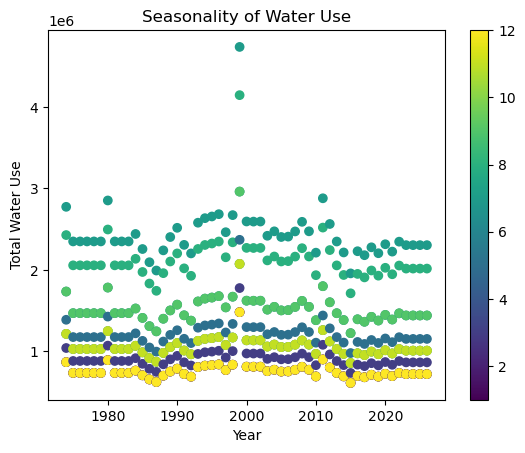

In [66]:
plt.scatter(wateruse_df['Year'], wateruse_df['Total Water'], c=wateruse_df['Month'], cmap='viridis')
plt.xlabel('Year')
plt.ylabel('Total Water Use')
plt.title('Seasonality of Water Use')
plt.colorbar()

In [67]:
# Importing weather data
weather_df = pd.read_csv(r"mega_weather.csv")

# Renaming columns
weather_df.columns = [
    'station_id', 'date', 'latitude', 'longitude', 'elevation', 'station_name',
    'average_dew_point_temp', 'average_dew_point_temp_attributes',
    'average_sea_level_pressure', 'average_sea_level_pressure_attributes',
    'average_station_pressure', 'average_station_pressure_attributes',
    'average_wet_bulb_temp', 'average_wet_bulb_temp_attributes',
    'average_wind_speed', 'average_wind_speed_attributes',
    'cooling_degree_days_season_to_date', 'cooling_degree_days_season_to_date_attributes',
    'cooling_degree_days', 'cooling_degree_days_attributes',
    'days_with_precip_>=0.01in', 'days_with_precip_>=0.01in_attributes',
    'days_with_precip_>=1.0in', 'days_with_precip_>=1.0in_attributes',
    'days_with_precip_>=2.0in', 'days_with_precip_>=2.0in_attributes',
    'days_since_precip', 'days_since_precip_attributes',
    'snow_depth', 'snow_depth_attributes',
    'days_with_min_temp_<=0F', 'days_with_min_temp_<=0F_attributes',
    'days_with_min_temp_<=32F', 'days_with_min_temp_<=32F_attributes',
    'days_with_max_temp_<=32F', 'days_with_max_temp_<=32F_attributes',
    'days_with_max_temp_>=70F', 'days_with_max_temp_>=70F_attributes',
    'days_with_max_temp_>=90F', 'days_with_max_temp_>=90F_attributes',
    'fog_days', 'fog_days_attributes',
    'days_heavy_fog', 'days_heavy_fog_attributes',
    'days_thunder', 'days_thunder_attributes',
    'days_sleet', 'days_sleet_attributes',
    'days_snow', 'days_snow_attributes',
    'days_tstorms', 'days_tstorms_attributes',
    'days_hail', 'days_hail_attributes',
    'days_freezing_rain', 'days_freezing_rain_attributes',
    'lowest_temp', 'lowest_temp_attributes',
    'max_snow_depth', 'max_snow_depth_attributes',
    'max_snowfall', 'max_snowfall_attributes',
    'max_precip', 'max_precip_attributes',
    'highest_temp', 'highest_temp_attributes',
    'evaporation', 'evaporation_attributes',
    'heating_degree_days_season_to_date', 'heating_degree_days_season_to_date_attributes',
    'snowfall_>=0.1in', 'snowfall_>=0.1in_attributes',
    'heating_degree_days', 'heating_degree_days_attributes',
    'highest_max_temp', 'highest_max_temp_attributes',
    'low_snowfall_>=0.1in', 'low_snowfall_>=0.1in_attributes',
    'lowest_max_temp', 'lowest_max_temp_attributes',
    'mean_temp_>=0.1in', 'mean_temp_>=0.1in_attributes',
    'mean_min_temp', 'mean_min_temp_attributes',
    'mean_temp_>=1.0in', 'mean_temp_>=1.0in_attributes',
    'mean_max_temp_>=1.0in', 'mean_max_temp_>=1.0in_attributes',
    'precipitation', 'precipitation_attributes',
    'percent_sunshine', 'percent_sunshine_attributes',
    'avg_relative_humidity', 'avg_relative_humidity_attributes',
    'min_relative_humidity', 'min_relative_humidity_attributes',
    'max_relative_humidity', 'max_relative_humidity_attributes',
    'snowfall', 'snowfall_attributes',
    'avg_temp', 'avg_temp_attributes',
    'max_temp', 'max_temp_attributes',
    'min_temp', 'min_temp_attributes',
    'sunshine_duration', 'sunshine_duration_attributes',
    'wind_direction_1min', 'wind_direction_1min_attributes',
    'wind_direction_2min', 'wind_direction_2min_attributes',
    'wind_direction_5min', 'wind_direction_5min_attributes',
    'wind_direction_gust', 'wind_direction_gust_attributes',
    'wind_direction_max', 'wind_direction_max_attributes',
    'wind_movement', 'wind_movement_attributes',
    'wind_speed_1min', 'wind_speed_1min_attributes',
    'wind_speed_2min', 'wind_speed_2min_attributes',
    'wind_speed_5min', 'wind_speed_5min_attributes',
    'wind_speed_gust', 'wind_speed_gust_attributes',
    'wind_speed_max', 'wind_speed_max_attributes'
]

# Drop attributes columns and irrelevant
weather_df = weather_df.drop(columns=[col for col in weather_df.columns if 'attributes' in col])
weather_df.drop(columns=['station_id', 'station_name', 'latitude', 'longitude', 'elevation'], inplace=True)

# Get number of NAs in each column
na_counts = weather_df.isna().sum()

# Filter columns with more than 50 NAs
for col in weather_df.columns:
    if na_counts[col] > 50:
        weather_df.drop(columns=[col], inplace=True)


# Convert date column to Year and Month columns
weather_df['Year'] = weather_df['date'].str[:4].astype(int)
weather_df['Month'] = weather_df['date'].str[5:7].astype(int)
weather_df.drop(columns=['date'], inplace=True)


# Add lagged features for temperature and precipitation
weather_df['lag1_avg_temp'] = weather_df['avg_temp'].shift(1)
weather_df['lag3_avg_temp'] = weather_df['avg_temp'].shift(3)   
weather_df['lag6_avg_temp'] = weather_df['avg_temp'].shift(6)
weather_df['lag12_avg_temp'] = weather_df['avg_temp'].shift(12)

weather_df['lag1_precipitation'] = weather_df['precipitation'].shift(1)
weather_df['lag3_precipitation'] = weather_df['precipitation'].shift(3)         
weather_df['lag6_precipitation'] = weather_df['precipitation'].shift(6)
weather_df['lag12_precipitation'] = weather_df['precipitation'].shift(12)

# Generate data for 06/2025 - 12/2025 (use mean of past data)
columns_to_avg = [col for col in weather_df.columns if col not in ['Year', 'Month', 'station_id', 'station_name']]
monthly_means = weather_df.groupby('Month')[columns_to_avg].mean()
needed_months = monthly_means.tail(7)
needed_months['Month'] = needed_months.index
needed_months['Year'] = [2025] * 7

weather_df = pd.concat([weather_df, needed_months], ignore_index = True)

You need to set up Copilot to use Chat.

In [68]:
# Importing Palmer Drought Severity Index (PDSI) data
pdsi_df = pd.read_csv("palmer_drought.csv", header=None)

# Alter column names
pdsi_df.columns = columns = ['Identifier', 'Jan_pdsi', 'Feb_pdsi', 'Mar_pdsi', 'April_pdsi', 'May_pdsi', 'June_pdsi', 'July_pdsi', 'Aug_pdsi', 'Sep_pdsi', 'Oct_pdsi', 'Nov_pdsi', 'Dec_pdsi']

# Convert the 'Identifier' column to string type
pdsi_df['Identifier'] = pdsi_df['Identifier'].astype(str)

# Get ID and Year from Identifier
pdsi_df['Region'] = pdsi_df['Identifier'].str[:6].astype(int)
pdsi_df['Year'] = pdsi_df['Identifier'].str[6:10].astype(int)

# Find Austin Edwards Aquifer Identifier
pdsi_df = pdsi_df[pdsi_df['Region'] == 410605]
pdsi_df.drop(columns=['Identifier', 'Region'], inplace=True)
pdsi_df.reset_index(drop=True, inplace=True)
pdsi_df.tail(3)

# Stacking all PDSI month values on top of each other into 1 column
pdsi_df = pdsi_df.melt(id_vars=['Year'], var_name='Month', value_name='PDSI')

# Remove '_pdsi' from the month column names
pdsi_df['Month'] = pdsi_df['Month'].str.replace('_pdsi', '')

# Change month names to numbers
month_map={
        'Jan' : 1, 'Feb': 2, 'Mar': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'Aug': 8,
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
pdsi_df['Month'] = pdsi_df['Month'].map(month_map)

# Sort by year
pdsi_df = pdsi_df.sort_values(by=['Year', 'Month']).reset_index(drop=True)

# Set 2025 data to monthly mean
data2025 = pdsi_df.groupby(['Month'], as_index=False)['PDSI'].mean()
mask_2025 = pdsi_df['Year'] == 2025
data2025_series = data2025.iloc[:,1]
data2025_series.index +=1
pdsi_df.loc[mask_2025, 'PDSI'] = pdsi_df.loc[mask_2025, 'Month'].map(data2025_series)

In [69]:
pdsi_df

,Year,Month,PDSI
0,1895,1,0.040000
1,1895,2,0.630000
2,1895,3,0.240000
3,1895,4,0.290000
4,1895,5,1.490000
...,...,...,...
1567,2025,8,-1.008550
1568,2025,9,-1.140534
1569,2025,10,-1.021756
1570,2025,11,-1.013893


In [70]:
# Import data for Standardized Precipitation
spi_df = pd.read_csv(r"spi_data_complete.csv")

# Create new years list
years = spi_df['Year']
new_years = []
for year in years:
    new_years.extend([year]*12)
new_years = [int(yr) for yr in new_years]

# Create new months list
new_months = []
base_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for j in range(0,len(spi_df)):
        new_months.extend(base_months)

spi_list = spi_df.iloc[:, 1:].to_numpy().flatten()
spi_df = pd.DataFrame({
      'Year' : new_years,
      'Month': new_months,
      'spi' : spi_list
})

# Get first row where 2023 is year, first row where 2024 is year
num_months = len(spi_df[spi_df['spi']==-9999.00])
start2023 = spi_df[spi_df['Year']==2023].index[12 - num_months]
start2024 = spi_df[spi_df['Year']==2024].index[12 - num_months]
start2025 = spi_df[spi_df['Year']==2025].index[12 - num_months]

# Replace all 2025 entries with average of 2023 and 2024
for i in range(0, num_months):
      spi_df.loc[start2025+i, 'spi'] = (spi_df.loc[start2023+i, 'spi'] + spi_df.loc[start2024+i, 'spi']) / 2

spi_df

,Year,Month,spi
0,1895,1,0.350
1,1895,2,1.010
2,1895,3,-0.970
3,1895,4,-0.910
4,1895,5,-1.300
...,...,...,...
1567,2025,8,0.150
1568,2025,9,0.605
1569,2025,10,-0.920
1570,2025,11,0.450


In [71]:
# Merge all dataframes [water_df, pop_df, wateruse_df, weather_df, pdsi_df] (align based on Year, Month)
# May have to explore later to determine if outer or inner merge better
# Inner merge: Only include rows if all columns have that year and month | Outer: Include all data (=> twice as much data but messier)
filter_method = 'outer'
master_df = water_df.merge(pop_df, on=['Year', 'Month'], how = filter_method)
master_df = master_df.merge(wateruse_df, on=['Year', 'Month'], how = filter_method)  # CULPRIT: causing number of rows to drop by 200
master_df = master_df.merge(weather_df, on=['Year', 'Month'], how = filter_method)   
master_df = master_df.merge(pdsi_df, on=['Year', 'Month'], how = filter_method)
master_df = master_df.merge(spi_df, on=['Year', 'Month'], how = filter_method)

# Sort data by year
master_df = master_df.sort_values(by=['Year', 'Month'])

# Filter years > 1947
master_df = master_df[master_df['Year'] > 1947]
master_df = master_df[master_df['Year'] < 2026]

# Reset the index after dropping rows
master_df = master_df.reset_index(drop=True)  

# Drop surface_area, reservior_storage, conservation_storage, percent_full bc too similar to target
master_df.drop(columns=['surface_area', 'reservoir_storage', 'conservation_storage', 'percent_full'], inplace=True)

# Make sure all feature names are strings and remove forbidden characters
master_df.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in master_df.columns]

# Fixing strange missing entries in water columns from 02/2016
for col in ['water_level', 'conservation_capacity', 'dead_pool_capacity', 'lag1_water_level', 'lag3_water_level', 'lag6_water_level', 'lag12_water_level']:
    master_df.loc[817, col] = master_df[col].mean()

print('Dimensions of combined dataset:', master_df.shape)
print('Max index of master dataframe:', master_df.index[-1])

Dimensions of combined dataset: (936, 66)
Max index of master dataframe: 935


In [72]:
master_df.columns = [str(col).replace('[', '').replace(']', '').replace('<', 'less').replace('>', 'greater') for col in master_df.columns]
master_df.columns

Index(['Year', 'Month', 'water_level', 'conservation_capacity',
       'dead_pool_capacity', 'lag1_water_level', 'lag3_water_level',
       'lag6_water_level', 'lag12_water_level', 'Population',
       'Municipal Groundwater', 'Municipal Surface Water',
       'Manufacturing Groundwater', 'Manufacturing Surface Water',
       'Mining Groundwater', 'Mining Surface Water', 'Power Groundwater',
       'Power Surface Water', 'Irrigation Groundwater',
       'Irrigation Surface Water', 'Livestock Groundwater',
       'Livestock Surface Water', 'Total Water', 'lag1_total_water',
       'lag3_total_water', 'lag6_total_water', 'lag12_total_water',
       'cooling_degree_days_season_to_date', 'cooling_degree_days',
       'days_with_precip_=0.01in', 'days_with_precip_=1.0in',
       'days_with_precip_=2.0in', 'days_since_precip', 'snow_depth',
       'days_with_min_temp_=0F', 'days_with_min_temp_=32F',
       'days_with_max_temp_=32F', 'days_with_max_temp_=70F',
       'days_with_max_temp_=90F'

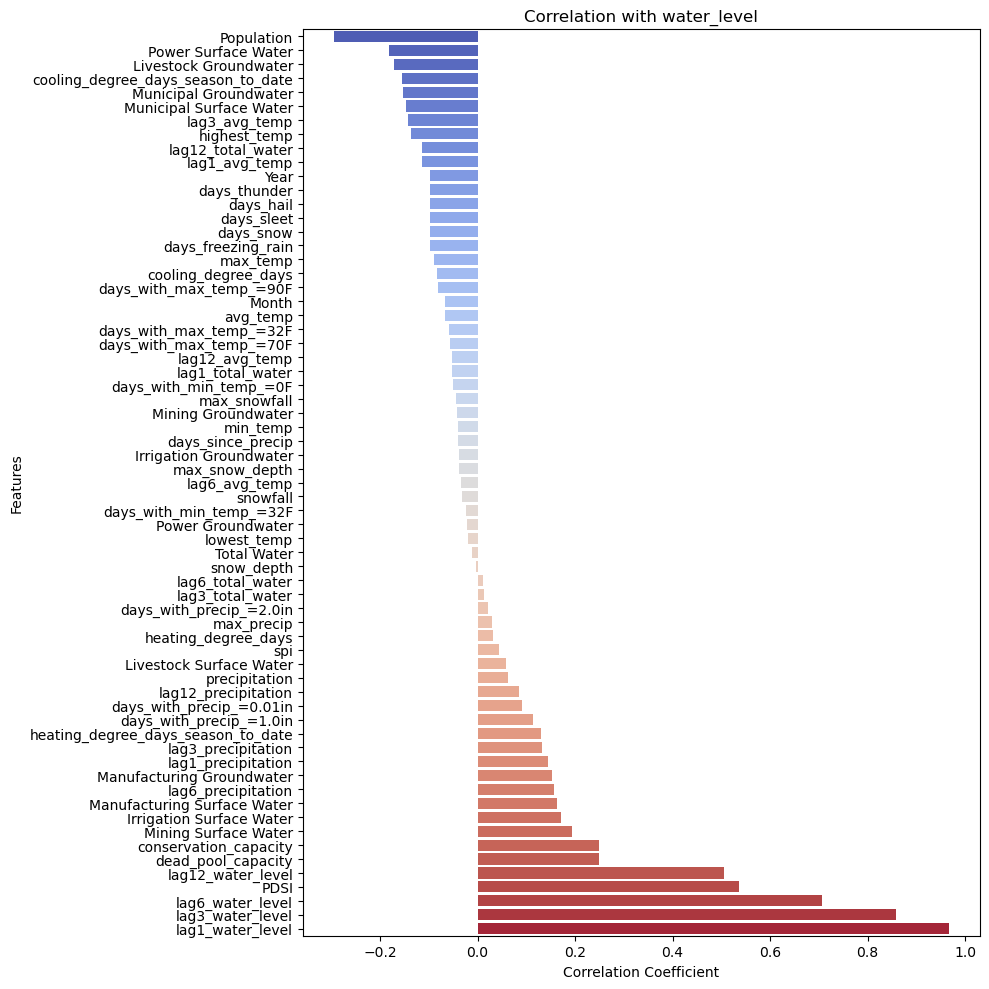

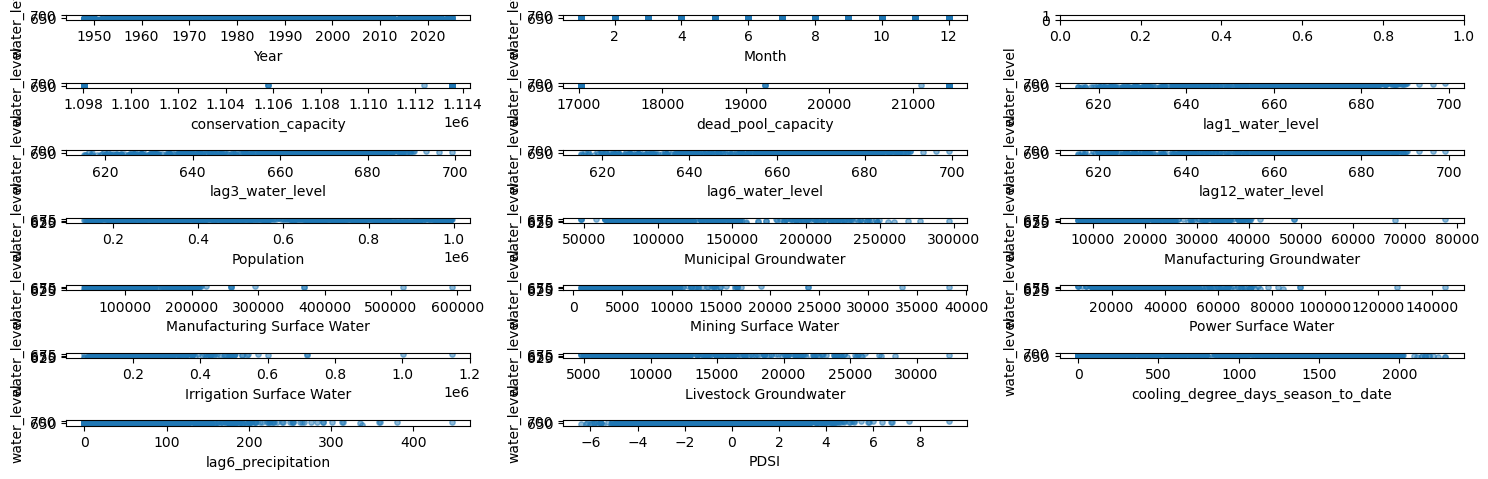

In [73]:
# Correlation between all features
corr_grid = master_df.corr()

# Choose the target feature
target = 'water_level'  # for example

# Get correlation of all features with the target
target_corr = corr_grid[target].drop(target).sort_values()

# Bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title(f'Correlation with {target}')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Collect features with promising correlation
correlated_features = []
skip_cols = ['water_level', 'station_id', 'station_name', 'surface_area', 'reservoir_storage', 'conservation_storage', 'percent_full', 'days_hail', 'days_sleet', 'days_snow', 'days_freezing_rain']
for col in master_df.columns:
    if col in skip_cols:
        continue
    if abs(master_df[target].corr(master_df[col])) > 0.15:
        correlated_features.append(col)

 # Filter master_df for best predictors
master_df = master_df.filter(['Year', 'Month', 'water_level'] + correlated_features)


# Initialize plots (Water Level v Feature)
fig, axes = plt.subplots(30, 3, figsize=(15,20))

# flatten so easier to iterate thru layout
axes = axes.flatten()    

# Loop thru and plot each feature of interest      
for i, col in enumerate(master_df.columns):
    if col in skip_cols:
        continue  # Skip the target column
    
    axes[i].scatter(master_df[col], master_df[target], alpha=0.5, s = 15)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

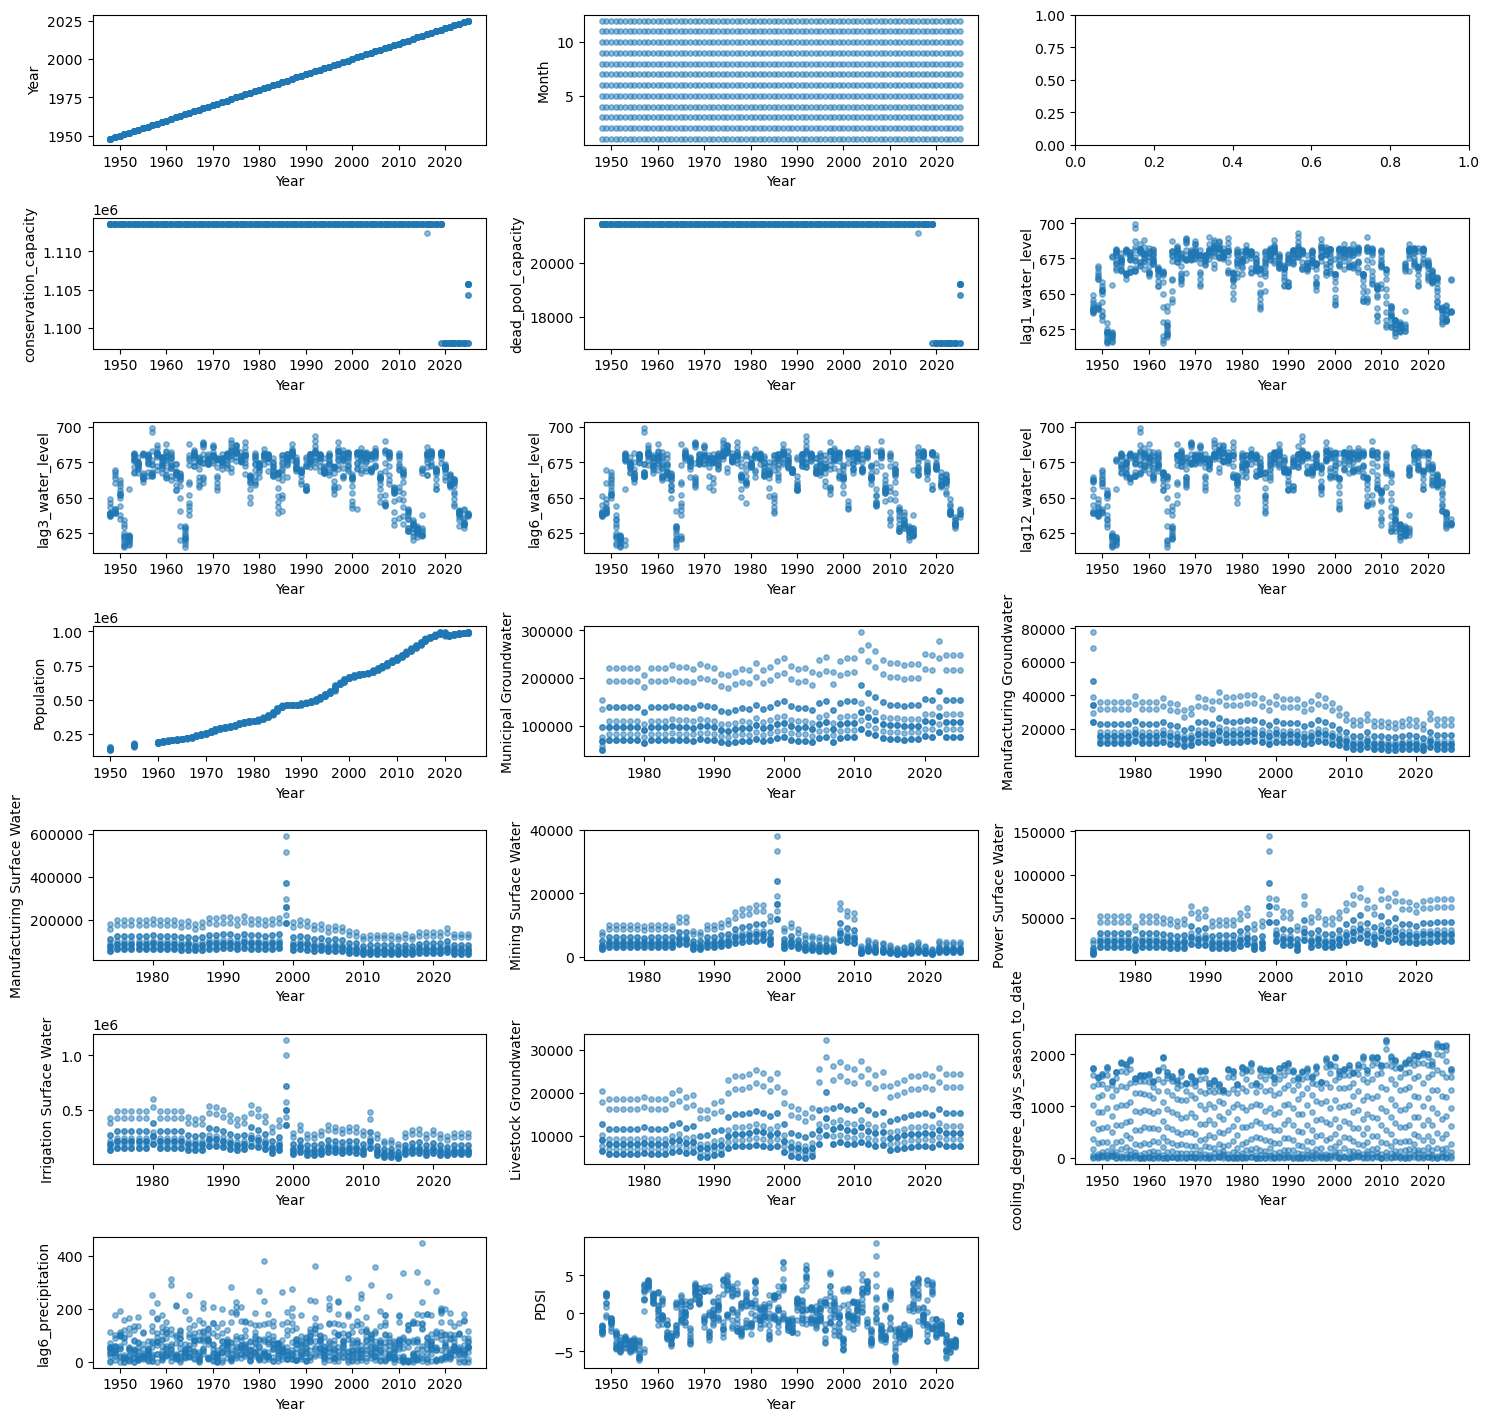

,Year,Month,water_level,conservation_capacity,dead_pool_capacity,lag1_water_level,lag3_water_level,lag6_water_level,lag12_water_level,Population,Municipal Groundwater,Manufacturing Groundwater,Manufacturing Surface Water,Mining Surface Water,Power Surface Water,Irrigation Surface Water,Livestock Groundwater,cooling_degree_days_season_to_date,lag6_precipitation,PDSI
0,1948,1,638.003226,1113531.0,21425.0,639.124839,638.967419,651.051613,663.023226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.400000,55.300000,-1.800000
1,1948,2,636.958966,1113531.0,21425.0,638.003226,638.883667,644.974839,664.913929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.900000,53.900000,-1.570000
2,1948,3,638.050323,1113531.0,21425.0,636.958966,639.124839,640.285667,662.270323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.400000,1.800000,-1.630000
3,1948,4,638.526667,1113531.0,21425.0,638.050323,638.003226,638.967419,661.921333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174.900000,0.500000,-1.730000
4,1948,5,639.360323,1113531.0,21425.0,638.526667,636.958966,638.883667,661.085161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,369.000000,52.700000,-2.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2025,8,NaN,1105787.5,19228.5,NaN,NaN,NaN,NaN,991984.916667,216926.489231,22445.424615,117536.935385,4053.904615,62815.049231,251060.072308,21252.118462,1309.475581,54.608140,-1.008550
932,2025,9,NaN,1105787.5,19228.5,NaN,NaN,NaN,NaN,992375.333333,154947.492308,16032.446154,83954.953846,2895.646154,44867.892308,179328.623077,15180.084615,1558.393023,56.803488,-1.140534
933,2025,10,NaN,1105787.5,19228.5,NaN,NaN,NaN,NaN,992765.750000,108463.244615,11222.712308,58768.467692,2026.952308,31407.524615,125530.036154,10626.059231,1678.237209,73.201163,-1.021756
934,2025,11,NaN,1104238.8,18789.2,NaN,NaN,NaN,NaN,993156.166667,108463.244615,11222.712308,58768.467692,2026.952308,31407.524615,125530.036154,10626.059231,1707.329070,115.746512,-1.013893


In [74]:
# Initialize plots  (Time v Feature)
target = 'Year'
fig, axes = plt.subplots(10, 3, figsize=(15,20))

# flatten so easier to iterate thru layout
axes = axes.flatten()    

# Loop thru and plot each feature of interest      
for i, col in enumerate(master_df.columns):
    if col in skip_cols:
        continue  # Skip the target column
    
    axes[i].scatter(master_df[target], master_df[col], alpha=0.5, s = 15)
    axes[i].set_xlabel(target)
    axes[i].set_ylabel(col)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
master_df

In [75]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

# DIAGNOSING MISSING ROWS
for df in [pop_df, wateruse_df, water_df, pdsi_df, spi_df, weather_df]:
    #print('Dimensions of', namestr(df, globals()), df.shape)
    #print('First year: ', df['Year'].iloc[0])
    #print('Last year:', df['Year'].iloc[-1])
    continue

In [76]:
# Graph actual vs predicted data, analyze whether residuals chronically +/-, check feature importances
def full_analysis(graph_title):
    # ERROR METRICS
    mae = mean_absolute_error(y_true, y_pred)
    mean_value = test_df['water_level'].mean()
    relative_mae = mae / mean_value
    print(f"Holdout MAE: {mae:.2f}")
    print(f"Relative MAE: {relative_mae:.2%}")
    # ACTUAL VS PREDICTED GRAPH
    plt.figure(figsize=(10,5))
    plt.plot(test_df.index, y_true, label="Actual", linewidth=2)
    plt.plot(test_df.index, y_pred, label="Predicted", linestyle='--')
    plt.title(graph_title)
    plt.xlabel("Index (time)")
    plt.ylabel("Water Level")
    plt.yticks([300, 350, 400, 450, 500, 550, 600, 650, 700])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # RESIDUALS
    residuals = y_true - y_pred
    plt.scatter(y_true, residuals, alpha=0.5)
    plt.axhline(0, color='red')
    plt.xlabel("Actual Water Level")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title("Residual Plot")
    plt.show()
    # FEATURE IMPORTANCES
    plot_importance(xgb_model, max_num_features=20)
    plt.title("All Feature Importances")
    plt.show()

In [77]:
# Filter to known (historical) data
historical_df = master_df[master_df['water_level'].notna()].reset_index(drop=True).copy()
print('Size of the master dataset:', master_df.shape)

# Set feature columns and target
using_lags = True
lag_cols = ['lag1_water_level', 'lag3_water_level', 'lag6_water_level', 'lag12_water_level']
base_features = historical_df.drop(columns=lag_cols + ['water_level']).columns.tolist()
features = base_features + (lag_cols if using_lags == True else [])
target = 'water_level'

# Chronological split (e.g., 80% train, 20% test)
split_idx = int(len(historical_df) * 0.8)
train_df = historical_df.iloc[:split_idx]
test_df  = historical_df.iloc[split_idx:]


def initialize_xgb(feature_data, target_data):

    # Fixed parameters set directly in model constructor
    xgb_model = XGBRegressor(
        # n_estimators,         Keep it modest; 100–200 often sufficient
        # max_depth,              Shallow trees generalize better on small data
        # learning_rate,       Conservative learning
        subsample = 0.8,         # Random sampling of rows
        colsample_bytree = 0.8,       # Random sampling of columns
        gamma=1,                # Minimum loss reduction required for split
        reg_alpha=1,            # L1 regularization (encourages sparsity)
        reg_lambda=1,           # L2 regularization (stabilizes weights)
        random_state=42
    )

    # Implementing GridSearchCV
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 4],
        'learning_rate': [0.05, 0.1],
    }

    # Fit grid search obj
    grid = GridSearchCV(estimator = xgb_model, param_grid = param_grid, cv = 3, scoring = 'neg_mean_absolute_error')
    grid.fit(feature_data, target_data)

    # Assuming your GridSearchCV object is called grid_search
    results = pd.DataFrame(grid.cv_results_)
    results['mean_test_score'] = results['mean_test_score'] * -1
    results = results.sort_values(by = 'mean_test_score', ascending = True)

    # Fit model with best parameters according to GridSearch
    xgb_model = grid.best_estimator_
    return results, xgb_model

# View results table
results_table, xgb_model = initialize_xgb(train_df[features], train_df[target])
results_table.head(2)


Size of the master dataset: (936, 20)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,0.187132,0.005184,0.013422,0.001302,0.1,3,200,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-6.276008,-2.127175,-2.399523,3.600902,1.894850,1
1,0.122857,0.016595,0.009401,0.002587,0.05,3,200,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",-6.515528,-2.120113,-2.183996,3.606546,2.057126,2


Holdout MAE: 2.64
Relative MAE: 0.40%


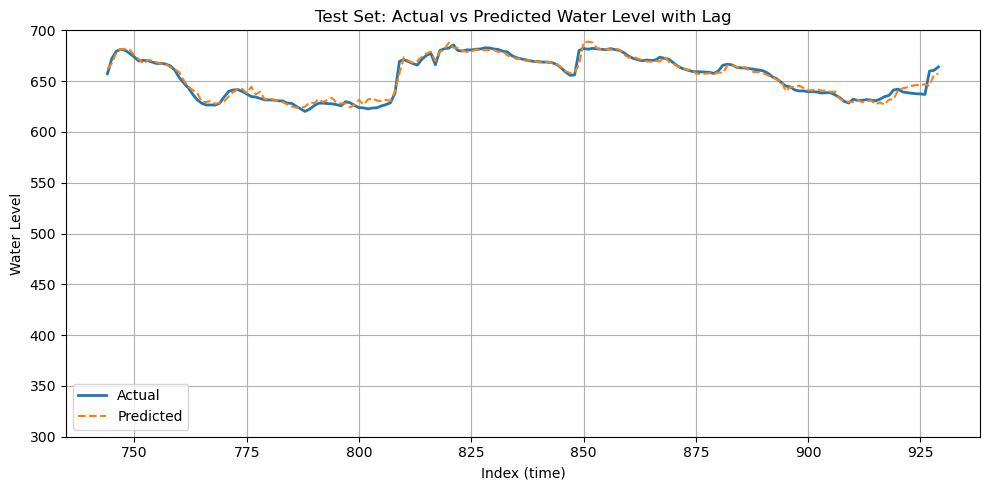

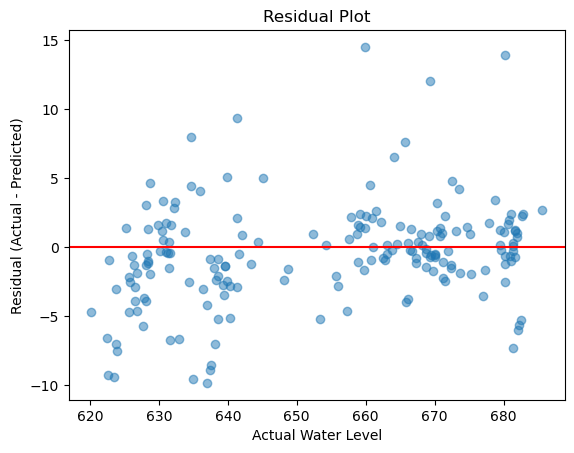

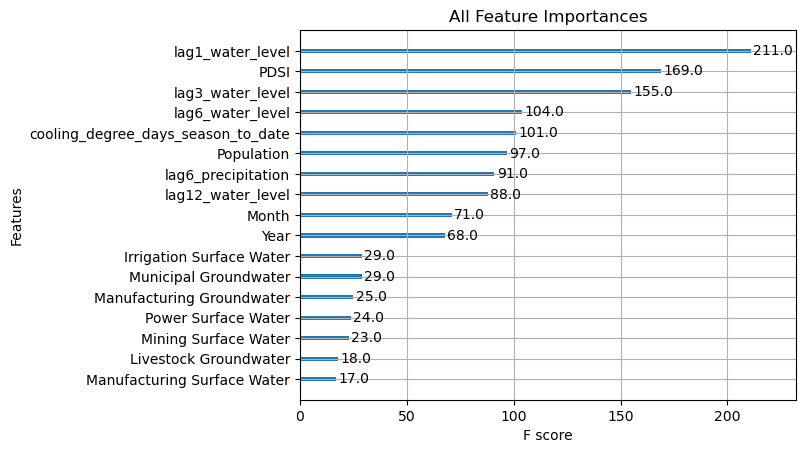

In [78]:
# Predict and evaluate on test set (TRUE LAG COLUMN INFO AVAILABLE)
y_pred = xgb_model.predict(test_df[features])
y_true = test_df[target].values

# full analysis with complete lag data
full_analysis("Test Set: Actual vs Predicted Water Level with Lag")

In [79]:
# Predict and evaluate on test set (FILL IN LAG VALUES FROM MODEL PREDICTIONS)

_, xgb_model = initialize_xgb(train_df[features], train_df[target])

# Make a copy of master df (cleaner and safer)
test_wo_lags = master_df.copy()  
y_true = test_df[target].values

# Initialize lag columns with NaN
for lag in [1, 3, 6, 12]:
    test_wo_lags.loc[test_df.index, f'lag{lag}_water_level'] = np.nan
test_wo_lags.loc[test_df.index, 'water_level'] = np.nan

# Get indices where water level is NaN
future_idx = test_wo_lags[test_wo_lags['water_level'].isna()].index

if using_lags:
    for idx in future_idx:
        lag_values = {}
        for lag in [1, 3, 6, 12]:
            # Compute lag index based on number of yrs lagged
            lag_idx = idx - lag
            if lag_idx >= 0 and not pd.isna(test_wo_lags.loc[lag_idx, 'water_level']):
                # Add value to lag_values if not NaN
                lag_values[f'lag{lag}_water_level'] = test_wo_lags.loc[lag_idx, 'water_level']  
            else:
                lag_values[f'lag{lag}_water_level'] = np.nan

        # Stop if any lag is missing — can't predict this row yet
        if any(pd.isna(v) for v in lag_values.values()):
            break

        # Fill lag columns for this row
        for col, val in lag_values.items():
            test_wo_lags.at[idx, col] = val

        # Predict using updated features
        X_future = test_wo_lags.loc[[idx], features]
        pred = xgb_model.predict(X_future)[0]

        # Write prediction into water_level column
        test_wo_lags.at[idx, 'water_level'] = pred
        

else:
    # No lags to maintain
    X_future = test_wo_lags.loc[future_idx, features]
    test_wo_lags.loc[future_idx, "water_level"] = xgb_model.predict(X_future)

y_pred = test_wo_lags.loc[test_df.index, 'water_level'].values

In [80]:
test_wo_lags = master_df.copy()  
y_true = test_df[target].values

# Initialize lag columns with NaN
for lag in [1, 3, 6, 12]:
    test_wo_lags.loc[test_df.index, f'lag{lag}_water_level'] = np.nan
test_wo_lags.loc[test_df.index, 'water_level'] = np.nan

test_wo_lags


,Year,Month,water_level,conservation_capacity,dead_pool_capacity,lag1_water_level,lag3_water_level,lag6_water_level,lag12_water_level,Population,Municipal Groundwater,Manufacturing Groundwater,Manufacturing Surface Water,Mining Surface Water,Power Surface Water,Irrigation Surface Water,Livestock Groundwater,cooling_degree_days_season_to_date,lag6_precipitation,PDSI
0,1948,1,638.003226,1113531.0,21425.0,639.124839,638.967419,651.051613,663.023226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.400000,55.300000,-1.800000
1,1948,2,636.958966,1113531.0,21425.0,638.003226,638.883667,644.974839,664.913929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.900000,53.900000,-1.570000
2,1948,3,638.050323,1113531.0,21425.0,636.958966,639.124839,640.285667,662.270323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.400000,1.800000,-1.630000
3,1948,4,638.526667,1113531.0,21425.0,638.050323,638.003226,638.967419,661.921333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174.900000,0.500000,-1.730000
4,1948,5,639.360323,1113531.0,21425.0,638.526667,636.958966,638.883667,661.085161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,369.000000,52.700000,-2.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2025,8,NaN,1105787.5,19228.5,NaN,NaN,NaN,NaN,991984.916667,216926.489231,22445.424615,117536.935385,4053.904615,62815.049231,251060.072308,21252.118462,1309.475581,54.608140,-1.008550
932,2025,9,NaN,1105787.5,19228.5,NaN,NaN,NaN,NaN,992375.333333,154947.492308,16032.446154,83954.953846,2895.646154,44867.892308,179328.623077,15180.084615,1558.393023,56.803488,-1.140534
933,2025,10,NaN,1105787.5,19228.5,NaN,NaN,NaN,NaN,992765.750000,108463.244615,11222.712308,58768.467692,2026.952308,31407.524615,125530.036154,10626.059231,1678.237209,73.201163,-1.021756
934,2025,11,NaN,1104238.8,18789.2,NaN,NaN,NaN,NaN,993156.166667,108463.244615,11222.712308,58768.467692,2026.952308,31407.524615,125530.036154,10626.059231,1707.329070,115.746512,-1.013893


Holdout MAE: 9.55
Relative MAE: 1.46%


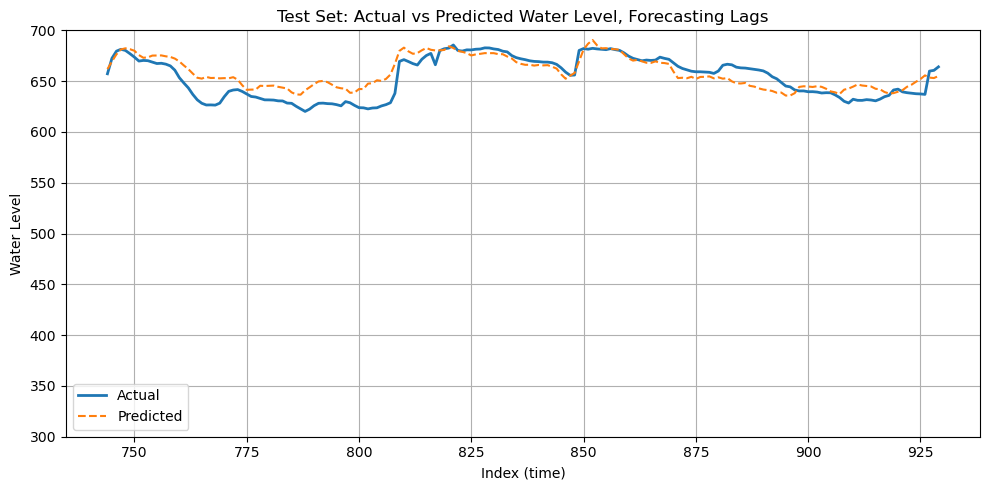

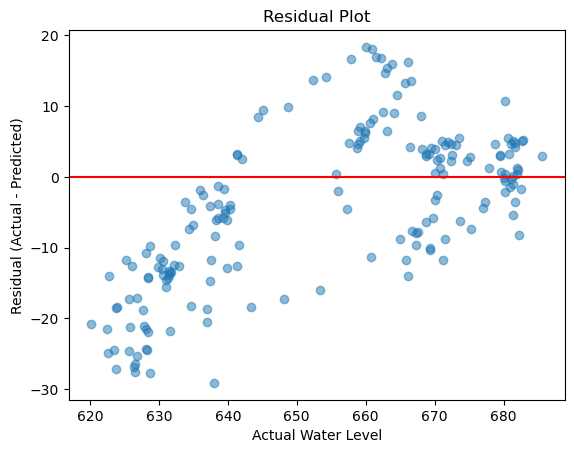

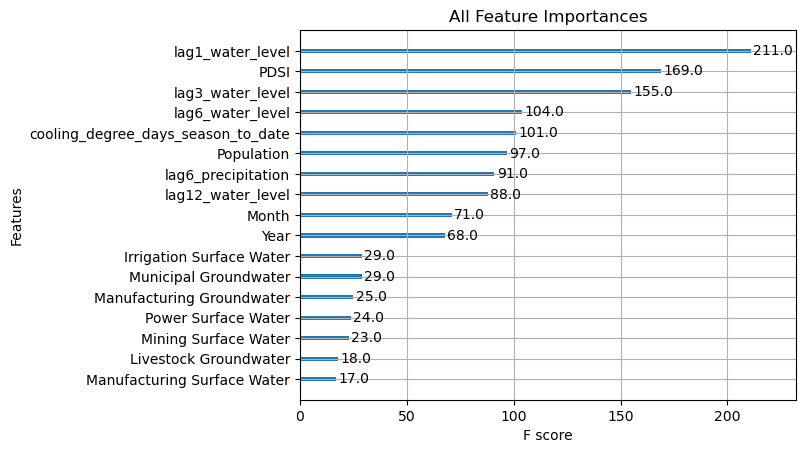

In [81]:
# Full analysis when forecasting lag
full_analysis("Test Set: Actual vs Predicted Water Level, Forecasting Lags")

In [82]:
# Fitting XGB Model to entire known dataset
_, xgb_model = initialize_xgb(historical_df[features], historical_df['water_level'])

# Recursive prediction for unseen rows

# Make a copy of master df (cleaner and safer)
full_df = master_df.copy()  
future_idx = master_df[master_df['water_level'].isna()].index
if using_lags:
    for idx in future_idx:
        lag_values = {}
        for lag in [1, 3, 6, 12]:
            # Compute lag index based on number of yrs lagged
            lag_idx = idx - lag
            if lag_idx >= 0 and not pd.isna(test_wo_lags.loc[lag_idx, 'water_level']):
                # Add value to lag_values if not NaN
                lag_values[f'lag{lag}_water_level'] = full_df.loc[lag_idx, 'water_level']  
            else:
                lag_values[f'lag{lag}_water_level'] = np.nan

        # Stop if any lag is missing — can't predict this row yet
        if any(pd.isna(v) for v in lag_values.values()):
            break

        # Fill lag columns for this row
        for col, val in lag_values.items():
            full_df.at[idx, col] = val

        # Predict using updated features
        X_future = full_df.loc[[idx], features]
        pred = xgb_model.predict(X_future)[0]

        # Write prediction into water_level column
        full_df.at[idx, 'water_level'] = pred

else:
    # No lags to maintain
    X_future = full_df.loc[future_idx, features]
    full_df.loc[future_idx, "water_level"] = xgb_model.predict(X_future)

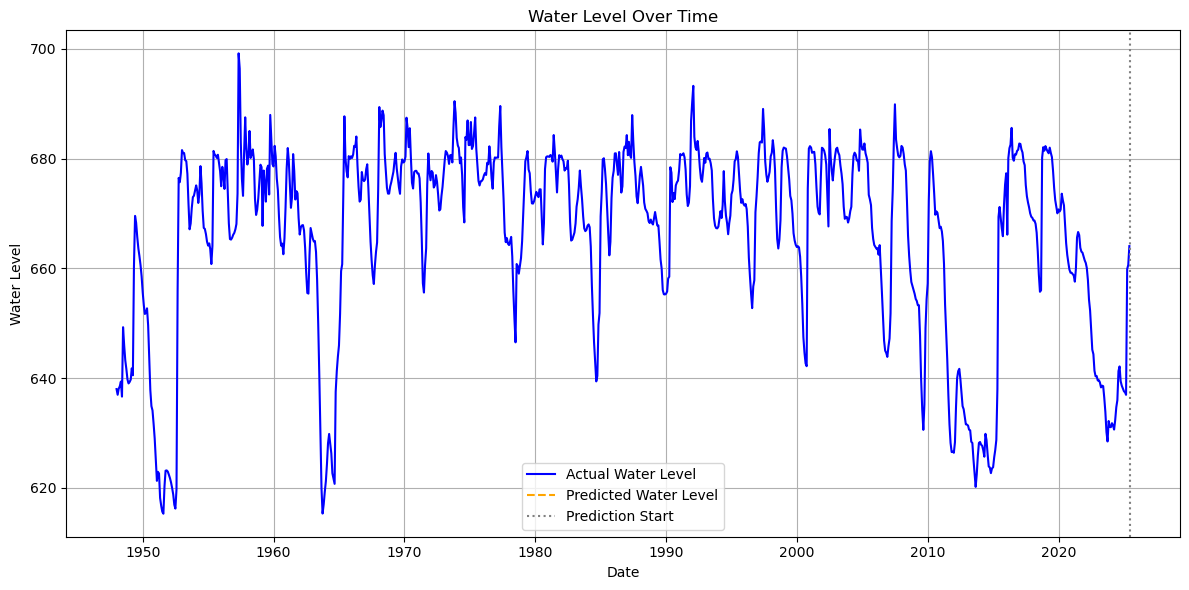

In [83]:
# Plotting actual and predicted
# Create a datetime column (1st of each month)
full_df['Date'] = pd.to_datetime(full_df['Year'].astype(str) + '-' + full_df['Month'].astype(str).str.zfill(2) + '-01')

# Identify where predictions start (NaNs originally)
full_df['is_predicted'] = full_df.index.isin(master_df[master_df['water_level'].isna()].index)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))

# Plot actual values (blue solid line)
plt.plot(full_df[~full_df['is_predicted']]['Date'],
         full_df[~full_df['is_predicted']]['water_level'],
         label='Actual Water Level', color='blue')

# Plot predicted values (orange dashed line)
plt.plot(full_df[full_df['is_predicted']]['Date'],
         full_df[full_df['is_predicted']]['water_level'],
         label='Predicted Water Level', color='orange', linestyle='--')

# Optional: draw vertical line where prediction starts
if full_df['is_predicted'].any():
    first_pred_date = full_df[full_df['is_predicted']]['Date'].iloc[0]
    plt.axvline(first_pred_date, color='gray', linestyle=':', label='Prediction Start')

# Plot formatting
plt.title('Water Level Over Time')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()